# Spam Detection

L'azienda ProfessionAI vuole realizzare una libreria capace di fare analisi delle email ricevute.

Nello specifico, il CEO ha richiesto di identificare le email di tipo SPAM sulle quali fare analisi contenutistiche.

Il CTO nello specifico ti fornisce un dataset e ti chiede di:
- Addestrare un classificatore per identificare SPAM
- Individuare i Topic principali tra le email SPAM presenti nel dataset
- Calcolare la distanza semantica tra i topics ottenuti, per dedurne l'eterogeneità.
- Estrarre dalle mail NON SPAM le Organizzazioni presenti.

# Addestrare un classificatore per identificare SPAM

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings

warnings.filterwarnings('ignore')
RANDOM_SEED = 42

In [2]:
df = pd.read_csv('spam_dataset.csv')

In [3]:
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0


- In label abbiamo ham e spam, rispettivamente le mail legittime e le mail indesiderate.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


- controlliamo la presenza di eventuali nulli.

In [5]:
df.isnull().sum()

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

- Eliminiamo la colonna degli ID.

In [6]:
df = df.drop("Unnamed: 0", axis=1)

In [7]:
df.head()

,label,text,label_num
0,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\nthis deal is to ...,0


- nel dataset potrebbero essere presenti osservazioni non in lingua inglese, utilizziamo la libreria langdetect per esplorare i nostri dati e tenere solo le mail in lingua inglese.

In [8]:
from langdetect import detect, DetectorFactory
import langdetect.lang_detect_exception as lang_detect_exception

DetectorFactory.seed = 0

def detect_language(text):
    try:
        return detect(text)
    except (lang_detect_exception.LangDetectException, TypeError):
        return "unknown"

df['language'] = df['text'].apply(detect_language)
df = df[df['language'] == 'en'].copy()
df.drop(columns=['language'], inplace=True)

- le osservazioni sono scese da 5171 a 5075.

In [9]:
df.shape

(5075, 3)

- contiamo le occorrenze di label, per comprendere il bilanciamento della distribuzione della nostra variabile target.

Ham: 3615 (71.23%)
Spam: 1460 (28.77%)


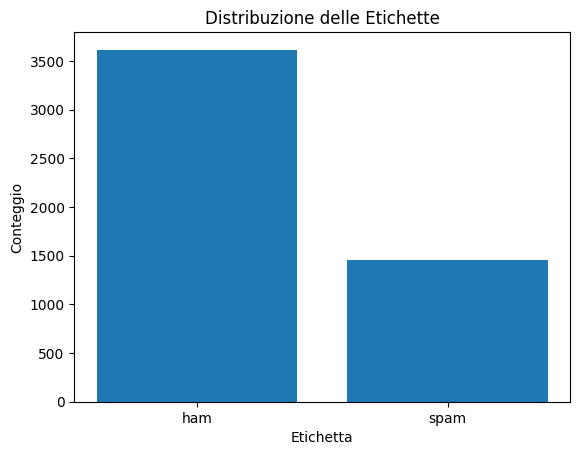

In [11]:
from collections import Counter
import matplotlib.pyplot as plt

# Conta le etichette
count = Counter(df["label"])
total = len(df["label"])

# Calcola le percentuali e stampa i risultati
for valore, counts in count.items():
    percentuale = (counts / total) * 100
    print(f"{valore.capitalize()}: {counts} ({percentuale:.2f}%)")

# Visualizza la distribuzione delle etichette in un grafico a barre
plt.bar(count.keys(), count.values())
plt.title("Distribuzione delle Etichette")
plt.xlabel("Etichetta")
plt.ylabel("Conteggio")
plt.show()


- come potevamo aspettarci le occorrenze di spam sono minori a quello di Ham, anche se il 29% del totale è comunque una quantità di record piuttosto rappresentativa.

In [12]:
df['text_length'] = df['text'].apply(len)
df.groupby('label')['text_length'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
ham,3615.0,972.497925,1367.117464,17.0,236.50,528.0,1225.50,31860.0
spam,1460.0,1218.182192,1812.258382,10.0,289.25,571.5,1255.25,21749.0


- In media i messaggi spam tendono ad essere leggermente più lunghi rispetto agli ham;
- In entrambi i casi è presente una deviazione std piuttosto alta, il che indica una grande variabilità nella lunghezza dei messaggi.

<Figure size 1200x600 with 0 Axes>

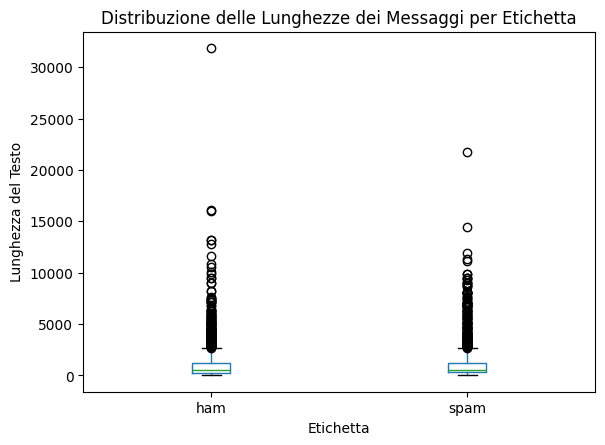

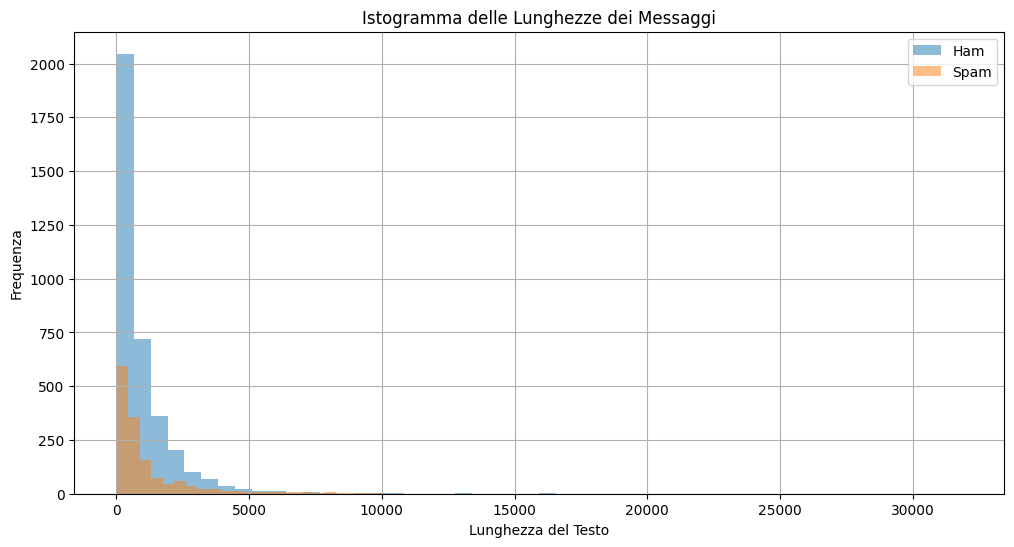

In [13]:
# Boxplot per visualizzare la distribuzione delle lunghezze dei messaggi
plt.figure(figsize=(12, 6))
df.boxplot(column='text_length', by='label', grid=False)
plt.title('Distribuzione delle Lunghezze dei Messaggi per Etichetta')
plt.suptitle('')
plt.xlabel('Etichetta')
plt.ylabel('Lunghezza del Testo')
plt.show()

# Istogramma delle lunghezze dei messaggi
plt.figure(figsize=(12, 6))
df[df['label'] == 'ham']['text_length'].hist(alpha=0.5, bins=50, label='Ham')
df[df['label'] == 'spam']['text_length'].hist(alpha=0.5, bins=50, label='Spam')
plt.title('Istogramma delle Lunghezze dei Messaggi')
plt.xlabel('Lunghezza del Testo')
plt.ylabel('Frequenza')
plt.legend(loc='upper right')
plt.show()


1. Boxplot:

- La maggior parte dei messaggi ha lunghezze relativamente brevi, come indicato dalle dimensioni compatte e simili dei box nelle categorie ham e spam.
- Ci sono molti outlier in entrambe le categorie, che rappresentano messaggi con lunghezze significativamente superiori rispetto al resto dei dati. L'outlier più evidente si trova nella categoria ham, con un messaggio che supera i 30.000 caratteri.
- La distribuzione delle lunghezze dei messaggi è fortemente asimmetrica, con una coda di messaggi più lunghi che produce numerosi outlier.

2. Istogramma:

- La distribuzione delle lunghezze dei messaggi per entrambe le categorie è fortemente asimmetrica, con una concentrazione molto alta di messaggi corti e una lunga coda di messaggi più lunghi.
- La maggior parte dei messaggi ha una lunghezza inferiore ai 1000 caratteri, con una frequenza molto alta di messaggi ham (in blu) rispetto ai messaggi spam (in arancione) per le lunghezze più brevi.
- I messaggi estremamente lunghi sono presenti in entrambe le categorie, ma sono più numerosi nei ham.

# Data Cleaning

Most Common Words:
-: 85593
.: 54126
/: 42622
,: 40261
the: 25573
:: 25035
to: 20318
ect: 13900
and: 12809
@: 12726
for: 10451
of: 10146
a: 9785
you: 8152
in: 7674
': 7502
on: 7298
hou: 7289
is: 7154
this: 7153


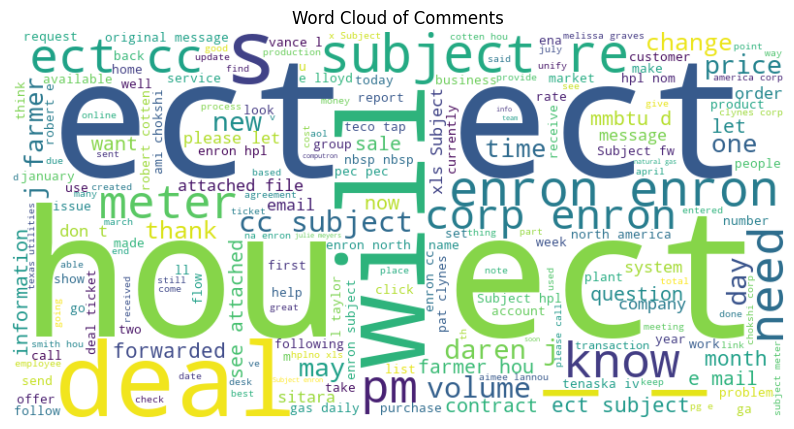

In [14]:
from wordcloud import WordCloud

# Combine all comments into a single text
all_text = ' '.join(df["text"])

# Count the words
word_counts = Counter(all_text.split())

# Display the most common words
most_common_words = word_counts.most_common(20)
print("Most Common Words:")
for word, count in most_common_words:
    print(f'{word}: {count}')

# Generate a Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments')
plt.show()

- Scarichiamo la lista delle stopwords inglesi, a cui aggiungiamo anche la parola "Subject". Successivamente carico un modello preaddestrato di spacy, che è progettato per l'analisi del testo in inglese e mi permette l'analisi delle sintassi e il riconoscimento delle entità.

In [15]:
import spacy
import string
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

import re

# importo il vettorizzatore TF-IDF, usato per convertire un doc in una matrice di caratteristiche TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

english_stopwords = set(stopwords.words("english") + ['subject', 'etc', 'ect', 'cc', 'hou'])# lista stopwords in inglese + alcune aggiunte di dominio.
punctuation = set(string.punctuation)
nlp = spacy.load("en_core_web_sm")

punct_re = re.compile(f'[{re.escape(string.punctuation)}]')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\deimo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


- Creiamo una funzione che prende una stringa di testo, la normalizza convertendo il tutto in minuscolo, rimuove la punteggiatura, lemmatizza le parole e filtra stopwords e numeri.

In [16]:
def data_cleaner(sentence):
    sentence = sentence.lower()
    sentence = punct_re.sub(" ", sentence)
    doc = nlp(sentence)
    return ' '.join(token.lemma_ for token in doc if token.text not in english_stopwords and not token.is_digit)

- Prepariamo i dati per l'analisi, assegnando ad X i testi elaborati applicando la funzione data_cleaner e a y le etichette associate ai testi

In [17]:
X = df["text"].apply(data_cleaner)
y = df["label"]

Most Common Words:
enron: 6426
com: 3697
deal: 3652
please: 3195
gas: 3025
meter: 2719
pm: 2340
thank: 2279
hpl: 2192
need: 2073
e: 1984
daren: 1901
forward: 1823
corp: 1776
get: 1695
know: 1691
volume: 1678
price: 1623
day: 1547
new: 1447


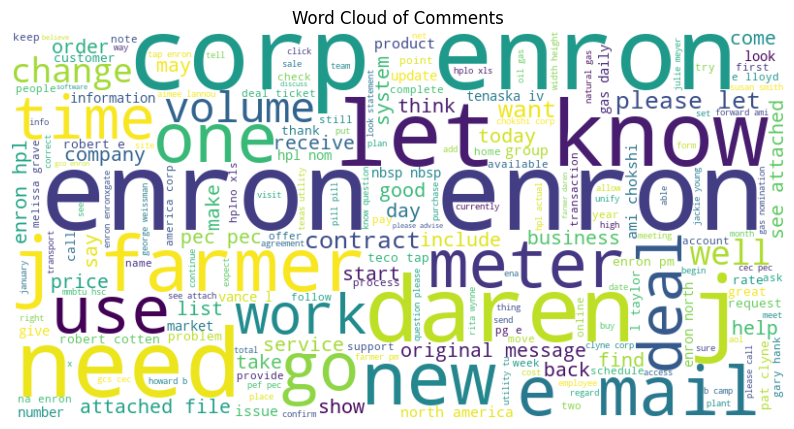

In [18]:
# Combine all comments into a single text
all_text = ' '.join(X)

# Count the words
word_counts = Counter(all_text.split())

# Display the most common words
most_common_words = word_counts.most_common(20)
print("Most Common Words:")
for word, count in most_common_words:
    print(f'{word}: {count}')

# Generate a Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Comments')
plt.show()

- Con il Vectorize trasformiamo i testi in una rappresentazione numerica basata su TF-IDF, raccogliendoli nella variabile X_transformed. Successivamente dividiamo il dataset in train e test.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Vettorizzazione
vectorizer = TfidfVectorizer(max_features=5000, min_df=5, max_df=0.7)
X_transformed = vectorizer.fit_transform(X)

# Suddivisione del dataset
X_train, X_test, y_train, y_test = train_test_split(X_transformed, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)


In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


In [21]:
# Logistic Regression
lr = LogisticRegression(random_state=RANDOM_SEED)
lr_scores = cross_val_score(lr, X_train, y_train, cv=5) # qui utilizziamo una cross validation a 5 fold
print(f"Logistic Regression CV Scores: {lr_scores.mean():.4f} (+/- {lr_scores.std() * 2:.4f})") # media dei punteggi e intervallo di confidenza 

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Logistic Regression Test Report:")
print(classification_report(y_test, y_pred))

Logistic Regression CV Scores: 0.9818 (+/- 0.0082)
Logistic Regression Test Report:
              precision    recall  f1-score   support

         ham       1.00      0.98      0.99       723
        spam       0.96      0.99      0.97       292

    accuracy                           0.99      1015
   macro avg       0.98      0.99      0.98      1015
weighted avg       0.99      0.99      0.99      1015



In [22]:
# MLP Classifier
mlp = MLPClassifier(random_state=RANDOM_SEED, max_iter=300)
mlp_scores = cross_val_score(mlp, X_train, y_train, cv=5) # qui utilizziamo una cross validation a 5 fold 
print(f"MLP Classifier CV Scores: {mlp_scores.mean():.4f} (+/- {mlp_scores.std() * 2:.4f})") # media dei punteggi e intervallo di confidenza 

mlp.fit(X_train, y_train)
y_pred = mlp.predict(X_test)
print("MLP Classifier Test Report:")
print(classification_report(y_test, y_pred))

MLP Classifier CV Scores: 0.9857 (+/- 0.0048)
MLP Classifier Test Report:
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       723
        spam       0.97      0.99      0.98       292

    accuracy                           0.99      1015
   macro avg       0.98      0.99      0.98      1015
weighted avg       0.99      0.99      0.99      1015



# Individuare i topic principali tra le email SPAM presenti nel dataset

In [25]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
spam_text = df[df['label'] == 'spam']['text'].apply(data_cleaner)

In [27]:
cv = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
dtm = cv.fit_transform(spam_text)

In [28]:
lda = LatentDirichletAllocation(n_components=5, random_state=RANDOM_SEED)
lda.fit(dtm)

LatentDirichletAllocation(n_components=5, random_state=42)

In [30]:
def print_topics(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        print(f"Topic {topic_idx}: {', '.join(top_features)}")


In [32]:
print_topics(lda, cv.get_feature_names_out(), 10)

Topic 0: font, td, http, nbsp, height, width, size, com, align, tr
Topic 1: account, com, cd, money, message, make, http, bank, email, time
Topic 2: price, adobe, window, software, professional, xp, office, microsoft, ms, photoshop
Topic 3: company, statement, stock, information, security, investment, report, price, look, business
Topic 4: com, http, www, pill, free, good, price, computron, remove, click


# DISTANZA SEMANTICA TRA I TOPICS

- Per calcolare la distanza semantica useremo la distanza di Jensen-Shannon, che misura la similarità tra distribuzioni di probabilità.

In [41]:
normalized_topics = []
for topic in lda.components_:
    normalized_topic = topic / np.sum(topic)
    normalized_topics.append(normalized_topic)

normalized_topics = np.array(normalized_topics)

In [42]:
for i, topic in enumerate(normalized_topics):
    print(f"Topic {i}:")
    print(f"  Somma: {np.sum(topic):.6f}")
    print(f"  Min: {np.min(topic):.6f}")
    print(f"  Max: {np.max(topic):.6f}")
    print(f"  Valori negativi: {np.any(topic < 0)}")
    print()

Topic 0:
  Somma: 1.000000
  Min: 0.000010
  Max: 0.026112
  Valori negativi: False

Topic 1:
  Somma: 1.000000
  Min: 0.000010
  Max: 0.008764
  Valori negativi: False

Topic 2:
  Somma: 1.000000
  Min: 0.000009
  Max: 0.007975
  Valori negativi: False

Topic 3:
  Somma: 1.000000
  Min: 0.000004
  Max: 0.020059
  Valori negativi: False

Topic 4:
  Somma: 1.000000
  Min: 0.000005
  Max: 0.014081
  Valori negativi: False



In [44]:
from scipy.spatial.distance import jensenshannon

def topic_distances(normalized_topics):
    n_topics = len(normalized_topics)
    distances = np.zeros((n_topics, n_topics))
    
    for i in range(n_topics):
        for j in range(i+1, n_topics):
            distance = jensenshannon(normalized_topics[i], normalized_topics[j])
            distances[i, j] = distance
            distances[j, i] = distance
    
    return distances

distances = topic_distances(normalized_topics)

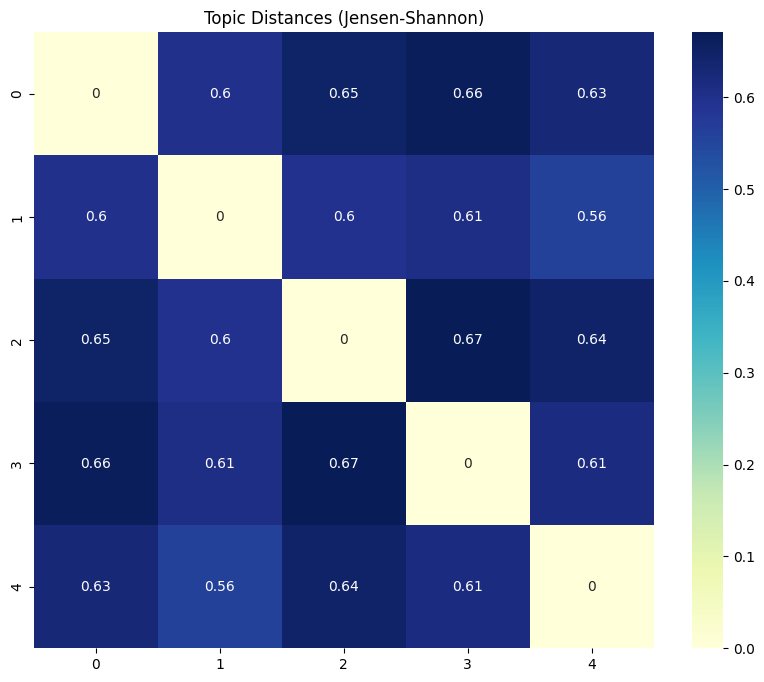

In [45]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(distances, annot=True, cmap='YlGnBu')
plt.title('Topic Distances (Jensen-Shannon)')
plt.show()

# Estrazione delle organizzazioni dalle email non spam

In [35]:
def extract_organizations(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ == 'ORG']

In [36]:
ham_texts = df[df['label'] == 'ham']['text']
organizations = ham_texts.apply(extract_organizations)

In [37]:
all_orgs = [org for orgs in organizations for org in orgs]
org_counts = Counter(all_orgs)

In [38]:
print("Top 10 Organizations in Non-Spam Emails:")
for org, count in org_counts.most_common(10):
    print(f"{org}: {count}")

Top 10 Organizations in Non-Spam Emails:
tenaska: 365
enron: 228
north america corp .: 185
ami chokshi / corp /: 153
exxon: 90
hplc: 88
pat clynes / corp / enron @ enron: 75
enron corp .: 53
pat clynes / corp /: 52
stella l morris: 51
